In [197]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [198]:
def toy_results_plot(data, data_generator=None, hypers=None, predictions=None):   
    train_x = np.arange(np.min(data[0][0].reshape(-1)),
                        np.max(data[0][0].reshape(-1)), 1/100)
    
    # plot the training data distribution
    if data_generator is not None:
        plt.plot(train_x, data_generator['mean'](train_x), 'red', label='data mean')
        plt.fill_between(train_x,
                         data_generator['mean'](train_x) - data_generator['std'](train_x),
                         data_generator['mean'](train_x) + data_generator['std'](train_x),
                         color='orange', alpha=1, label='data 1-std')
    plt.plot(data[0][0], data[0][1], 'r.', alpha=0.2, label='train sampl')

    # plot the model distribution
    if predictions is not None:
        x = predictions[0]
        y_mean   = predictions[1]['mean'][:,0]
        ell_mean = predictions[1]['mean'][:,1]
        y_var    = predictions[1]['cov'][:,0,0]
        ell_var  = predictions[1]['cov'][:,1,1]
        
        if hypers['style'] != 'heteroskedastic':
            ell_mean = hypers["homo_logvar_scale"]
            ell_var = 0

        heteroskedastic_part = np.exp(0.5 * ell_mean)
        full_std = np.sqrt(y_var + np.exp(ell_mean + 0.5 * ell_var))

        plt.plot(x, y_mean, label='model mean')
        plt.fill_between(x,
                         y_mean - heteroskedastic_part,
                         y_mean + heteroskedastic_part,
                         color='g', alpha = 0.2, label='$\ell$ contrib')
        plt.fill_between(x,
                         y_mean - full_std,
                         y_mean + full_std,
                         color='b', alpha = 0.2, label='model 1-std')
        
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim([-3,2])
    plt.legend()
    plt.show()


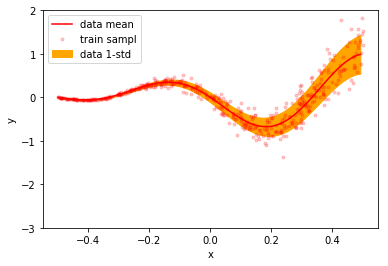

In [221]:
def base_model(x):
    return -(x+0.5)*np.sin(3 * np.pi *x)

def noise_model(x):
    return 0.45*(x+0.5)**2

def sample_data(x):
    return base_model(x) + np.random.normal(0, noise_model(x))

data_size = {'train': 500, 'valid': 100, 'test': 100}
toy_data = []

for section in ['train', 'valid', 'test']:
    x = (np.random.rand(data_size['train'], 1) - 0.5)
    toy_data.append([x, sample_data(x).reshape(-1)]) 
    
x = np.arange(-1, 1,  1/100)
toy_data.append([[[_] for _ in x], base_model(x)])

toy_results_plot(toy_data, {'mean':base_model, 'std':noise_model})

In [274]:
def matrix_diag_part(tensor):
    return torch.stack(tuple(t.diag() for t in torch.unbind(tensor,0)))

In [366]:
class LinearGaussian(nn.Module):
    def __init__(self, in_dim, out_dim, certain=False, prior=None):
        
        super().__init__()
        
        self.A_mean = nn.Parameter(torch.Tensor(in_dim, out_dim))
        self.b_mean = nn.Parameter(torch.Tensor(out_dim))
        self.certain = certain
        
        self.A_var = nn.Parameter(torch.Tensor(in_dim, out_dim))
        self.b_var = nn.Parameter(torch.Tensor(out_dim))
        
        self.__initialize_weights()
        
    
    def __initialize_weights(self):
        nn.init.zeros_(self.A_mean)
        nn.init.zeros_(self.b_mean)
        nn.init.xavier_normal_(self.A_var)
        nn.init.normal_(self.b_var)

        
    def forward(self, x):
        
        if self.certain:
            x_mean = x
            x_var = None
        else:
            x_mean = x[0]
            x_var = x[1]
        
        y_mean = F.linear(x_mean, self.A_mean.t()) + self.b_mean
        
        if self.certain:
            xx = x_mean * x_mean
            y_var = torch.diag_embed(F.linear(xx, self.A_var.t()) + self.b_var)
        else:
            y_var = self.compute_var(x_mean, x_var)
        
        return (y_mean, y_var)      

    def compute_var(self, x_mean, x_var):
        x_var_diag = matrix_diag_part(x_var)
        xx_mean = x_var_diag + x_mean * x_mean
        
        term1_diag = torch.matmul(xx_mean, self.A_var)
        
        flat_xCov = torch.reshape(x_var, (-1, self.A_mean.size(0)))  # [b*x, x]
        xCov_A = torch.matmul(flat_xCov, self.A_mean)  # [b * x, y]
        xCov_A = torch.reshape(xCov_A, (-1, self.A_mean.size(0), self.A_mean.size(1))) # [b, x, y]
        xCov_A = torch.transpose(xCov_A, 1, 2)  # [b, y, x]
        xCov_A = torch.reshape(xCov_A, (-1, self.A_mean.size(0)))  # [b*y, x]
        
        A_xCov_A = torch.matmul(xCov_A, self.A_mean)  # [b*y, y]
        A_xCov_A = torch.reshape(A_xCov_A, (-1, self.A_mean.size(1), self.A_mean.size(1)))  # [b, y, y]
        
        term2 = A_xCov_A
        term2_diag = matrix_diag_part(term2)
        
        term3_diag = self.b_var
        result_diag = term1_diag + term2_diag + term3_diag
        return torch.diag_embed(result_diag)

In [367]:
reg = LinearGaussian(1, 2, certain=True)

In [368]:
x_train.shape

torch.Size([500, 1])

In [369]:
yy = reg(x_train)

In [370]:
yy[0][0]

tensor([0., 0.], grad_fn=<SelectBackward>)

In [375]:
yy[0].shape, yy[1].shape

(torch.Size([500, 2]), torch.Size([500, 2, 2]))

In [376]:
reg = nn.Sequential(
    LinearGaussian(1, 2, certain=True),
    LinearGaussian(2, 1)
)

In [377]:
yy = reg(x_train)

In [378]:
yy[1].shape

torch.Size([500, 1, 1])

In [379]:
yy[0].shape, yy[1].shape

(torch.Size([500, 1]), torch.Size([500, 1, 1]))

In [256]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 5)
        self.linear2 = nn.Linear(5, 5)
        self.linear3 = nn.Linear(5, 5)
        self.linear4 = nn.Linear(5, 1)
    
    def forward(self, x):
        x = self.linear2(F.leaky_relu(self.linear1(x)))
        x = self.linear4(F.leaky_relu(self.linear3(x)))
        return x

In [257]:
model = Regressor()

In [258]:
x_train, y_train = toy_data[0][0], toy_data[0][1]

In [259]:
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)

In [260]:
optim = torch.optim.Adam(model.parameters())

In [261]:
mse = nn.M()

In [262]:
from IPython.display import clear_output

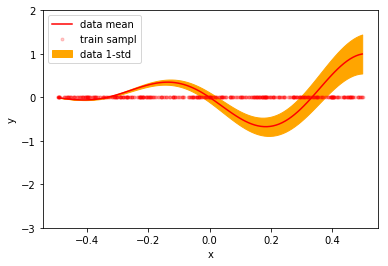

epoch: 1001, train loss : 0.225360
epoch: 1101, train loss : 0.225359
epoch: 1201, train loss : 0.225359
epoch: 1301, train loss : 0.225359
epoch: 1401, train loss : 0.225359


KeyboardInterrupt: 

In [263]:
epochs = 20000
for epoch in range(epochs):
    model.train()
    y_ans = model(x_train)
    loss = mse(y_ans, y_train)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if epoch % 100 == 0:
        if epoch % 1000 == 0:
            clear_output()            
            model.eval()
            
            x = toy_data[1][0]
            y_true = toy_data[1][1]
            y_pred = model(torch.FloatTensor(x))
            
            plt.figure()
            toy_results_plot([[x, y_pred.detach().numpy()]], {'mean':base_model, 'std':noise_model})
            
        print("epoch: {}, train loss : {:.6f}".format(epoch + 1, loss.item()))

In [ ]:
x = toy_data[1][0]
y_true = toy_data[1][1]

y_pred = model(torch.FloatTensor(x))

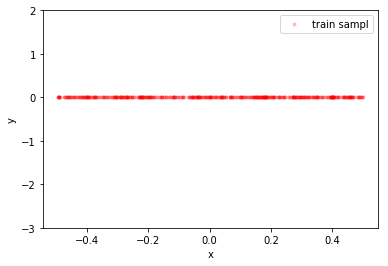

In [255]:
toy_results_plot([[x, y_pred.detach().numpy()]])

In [264]:
from sklearn.linear_model import LinearRegression

In [265]:
reg = LinearRegression()
reg.fit(x, y_true)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)